<a href="https://colab.research.google.com/github/mdrapha/machine-learning/blob/main/MLP-House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Universidade Federal de São Paulo
# Atividade 2 de IA
###Aprendizagem de Máquina II(Tarefa de Regressão com RNAs e Mapas)
Fazendo uso do Dataset "House_Sale", para estimar valores de venda de propriedades por uso de redes neurais
Integrantes:
*     Marco Antonio Coral dos Santos       RA: 158467
*     Raphael Damasceno Rocha de Moraes    RA:156380



Obs.: O arquivo no GitHub teve de ser carregado sem o mapa interativo com as propriedades por conta de seu tamanho total para que o mesmo pudesse ser exibido visualmente na plataforma.

In [ ]:
#Importacao das bibliotecas e funcoes usadas
import torch as t
import torch.nn as nn
import pandas as pd
import numpy as np
import zipfile as z
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import transforms
!pip install torchmetrics
from torchmetrics import MeanAbsolutePercentageError
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Acessando os dados do dataset

In [ ]:
#Abrindo o arquivo zipado
zf = z.ZipFile('/content/drive/MyDrive/Data/House_Sale/House_Sale.zip')
data = pd.read_csv(zf.open('kc_house_data.csv'))


In [ ]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


Remoção dos dados não interessantes para o modelo

In [ ]:
#Descartando os dados que não serão utilizados (id)
data = data.drop(['id', 'date', 'lat', 'long'], axis=1)

Visualização dos dados e seus rótulos

In [ ]:
print(data.shape)
print(data.head())

(21613, 17)
      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7      1180.0              0      1955             0   
1     0          3      7      2170.0            400      1951          1991   
2     0          3      6       770.0              0      1933             0   
3     0          5      7      1050.0            910      1965             0   
4     0          3      8      1680.0              0      1987             0   

   zipcode  sqft_living15  sqft_

Quantidade de rótulos

In [ ]:
data.columns.values.shape

(17,)

Informações sobre os tipos de cada um dos dados

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21611 non-null  float64
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  sqft_living15  21613 non-null  int64  
 16  sqft_lot15     21613 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 2.8 MB


Verificação de dados


In [ ]:
data.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64

Remoção dos dados incompletos

In [ ]:
#Remoçao dos conjuntos de dados incompletos
data=data.drop(np.where(data['sqft_above'].isnull().values==True)[0])

Verificação se os dados foram removidos

In [ ]:
data.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64

#Plotagem da Scatter Matrix dos dados

In [ ]:
import plotly.express as px

fig = px.scatter_matrix(data, dimensions=data.columns[0:18])#,color=data_train.columns[8])
fig.update_layout(
    autosize=True,
    width=3000,
    height=3000,
)
fig.update_yaxes(automargin=True)

fig.show()

Tabela de correlação entre os dados

In [ ]:
#Tabela de correlação
corr = data.corr()
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
price,1.000000,0.308366,0.525150,0.702055,0.089661,0.256814,0.266371,0.397299,0.036379,0.667434,0.605567,0.323842,0.054006,0.126436,-0.053182,0.585377,0.082448
bedrooms,0.308366,1.000000,0.515974,0.576763,0.031710,0.175418,-0.006581,0.079537,0.028433,0.356998,0.477616,0.303251,0.154248,0.018844,-0.152717,0.391670,0.029252
bathrooms,0.525150,0.515974,1.000000,0.754684,0.087730,0.500712,0.063743,0.187735,-0.124917,0.664981,0.685363,0.283737,0.505968,0.050733,-0.203825,0.568626,0.087163
sqft_living,0.702055,0.576763,0.754684,1.000000,0.172841,0.354048,0.103829,0.284647,-0.058689,0.762727,0.876644,0.434925,0.318066,0.055377,-0.199342,0.756440,0.183301
sqft_lot,0.089661,0.031710,0.087730,0.172841,1.000000,-0.005206,0.021602,0.074705,-0.008951,0.113617,0.183511,0.015301,0.053061,0.007640,-0.129583,0.144605,0.718556
floors,0.256814,0.175418,0.500712,0.354048,-0.005206,1.000000,0.023695,0.029432,-0.263808,0.458208,0.523899,-0.245634,0.489361,0.006330,-0.059181,0.279907,-0.011275
waterfront,0.266371,-0.006581,0.063743,0.103829,0.021602,0.023695,1.000000,0.401857,0.016655,0.082775,0.072074,0.080618,-0.026172,0.092883,0.030283,0.086463,0.030702
view,0.397299,0.079537,0.187735,0.284647,0.074705,0.029432,0.401857,1.000000,0.045995,0.251320,0.167648,0.277051,-0.053474,0.103912,0.084819,0.280440,0.072569
condition,0.036379,0.028433,-0.124917,-0.058689,-0.008951,-0.263808,0.016655,0.045995,1.000000,-0.144647,-0.158206,0.174273,-0.361384,-0.060617,0.002967,-0.092795,-0.003397
grade,0.667434,0.356998,0.664981,0.762727,0.113617,0.458208,0.082775,0.251320,-0.144647,1.000000,0.755924,0.168375,0.446958,0.014412,-0.184842,0.713197,0.119243


Matriz com os valores de correlação

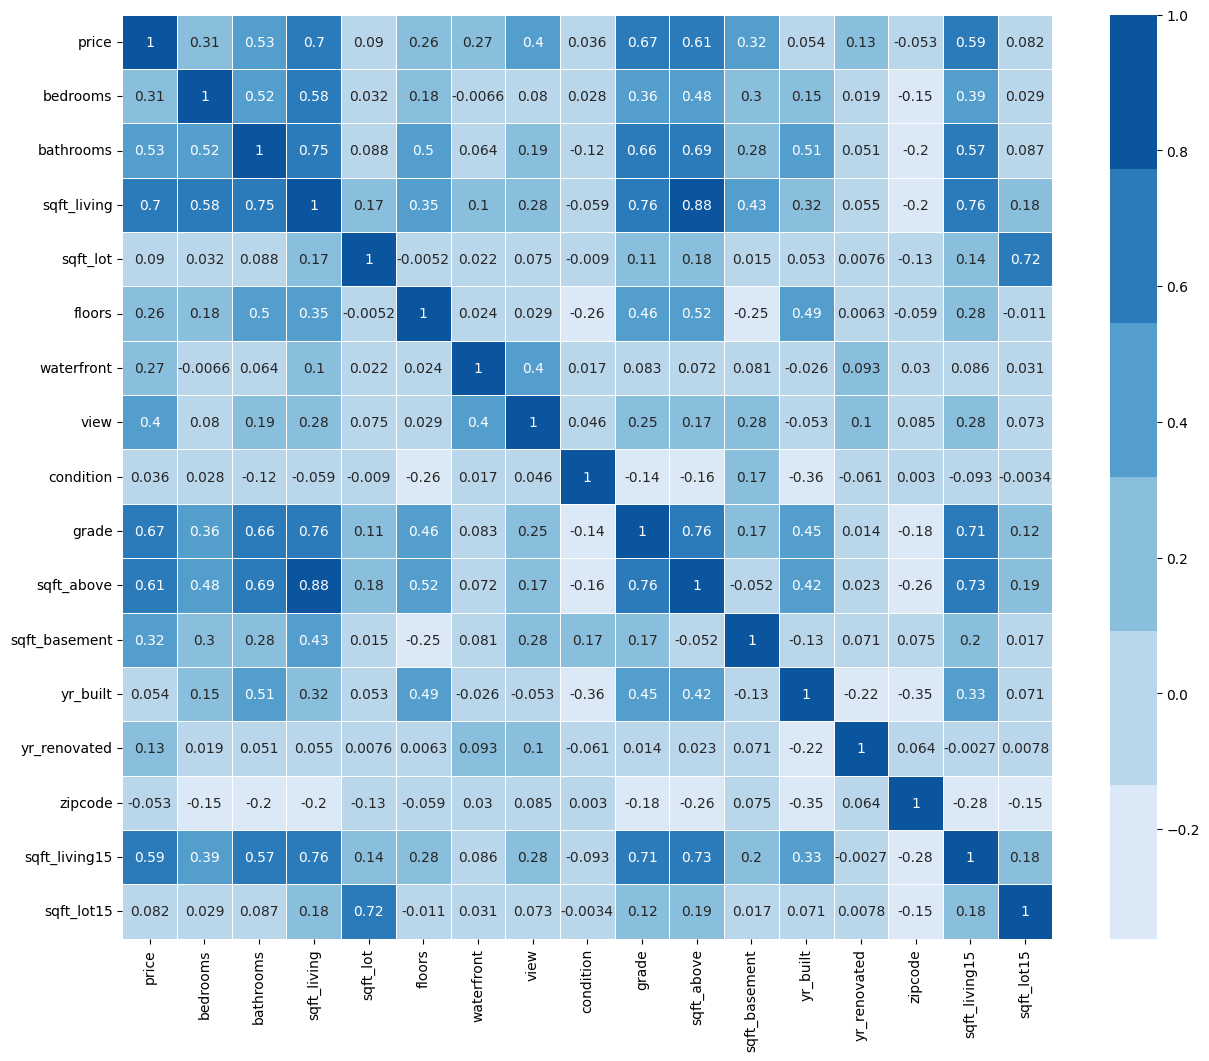

In [ ]:
# Melhor visualização  da correlação
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, cmap=sns.color_palette("Blues"), linewidths=.5, annot=True);

Definição dos conjuntos de dados de entrada e saída

In [ ]:
#Definindo o conjunto de entrada e saida
X=np.array(data.values[:,1:17], dtype=float)
print(X.shape)
Y=np.array(data.values[:,0], dtype=float)
print(Y.shape)

np_data=np.array(data.values[:,0:17], dtype=float)
data_save=data

(21611, 16)
(21611,)


#Definindo a rede neural
Aplicando 3 camadas com a função de suavização ReLU

In [ ]:
#Definindo a rede neural

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(16, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        )

    def forward(self, x):
        x=x.float()
        return self.layers(x)




Tratamento dos dados para o formato $tensor$

In [ ]:
#Tratamento dos dados para o formato tensor
#Conversao de uma array do np para tensor
t_X=t.from_numpy(X)
t_Y=t.tensor(Y)

print(type(t_X))
print(type(t_Y))


<class 'torch.Tensor'>
<class 'torch.Tensor'>


Definição do protocolo de validação cruzada (k-fold)
*    5 partes
*    Com embaralhamento dos dados (shuffle)

In [ ]:
#Aplicando o protocolo experimental de validação cruzada (k-fold) 
#para dividir o conjunto de dados em 5 partes
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)

#Treinamento de validação da rede

In [ ]:
#Treinando a rede neural

#Definindo a metrica de Loss
mean_abs_percentage_error = MeanAbsolutePercentageError()


#Definindo um matriz para armazenar os valores 
#das acurácias de cada epoch de cada fold
loss_list= [[0] * 5 for i in range(100)]
#Setando um valor alto inicial para a variável
best_acc=1

#Salvando os valores de f(x) e h(x) de cada amostra
hx_list = [[] for _ in range(5)]
fx_list = [[] for _ in range(5)]

#Dicionário para armazenar os valores finais de Loss do conjunto de teste
test_loss_list=[]

#Aplicando o protocolo k-fold
print('============================================')
for fold, (train_ids,test_ids) in enumerate(kf.split(t_X)):
    print(f'FOLD {fold+1}')
    print('============================================')

    #Definindo os dados de treino e teste
    train_subsampler = t.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = t.utils.data.SubsetRandomSampler(test_ids)

    #Definindo o dataset
    dataset = t.utils.data.TensorDataset(t_X, t_Y)

    # Definicao dos dados a serem carregados para treino e teste na particao(fold) atual
    trainloader = t.utils.data.DataLoader(
                      dataset, 
                      batch_size=100, sampler=train_subsampler)
    testloader = t.utils.data.DataLoader(
                      dataset,
                      batch_size=100, sampler=test_subsampler)
    
    #Definindo os parametros e hyper-parameters
    net=Net()
    optimizer=optim.SGD(net.parameters(), lr=0.001)
    best_model_fold=net
    best_model=net
    #Definindo o melhor modelo para cada fold
    best_fold_acc=0

    #Rodando os treinos para o numero definido de epochs
    n_epochs=100
    for epoch in range(0, n_epochs):
      for i, data in enumerate(trainloader, 0):
        inputs,targets=data
        targets=targets.long()
        optimizer.zero_grad()
        outputs=net(inputs)
        outputs=outputs.squeeze()
        loss=mean_abs_percentage_error(outputs,targets)
        loss_list[epoch][fold]=loss.detach().numpy()
        loss.backward()
        optimizer.step()
        
        best_fold_acc=loss.item()
        if loss.item() < best_fold_acc:
          # Salvando o modelo da fold atual
          best_fold_acc=loss.item()
          best_model_fold=net
          

        #Verificando o melhor modelo de todas as fold  
        if loss.item() < best_acc:
          best_acc=loss.item()
          best_model=net
        
      print('Epoch %d, Final Loss: %.4f, Best Loss: %.4f' % (epoch+1, loss.item(), best_acc))
    # Rodando o conjunto de teste sobre o melhor modelo da fold atual
    best_model_fold.eval()
    test_loss = 0.0
    with t.no_grad():
        hx_auxvector = []
        fx_auxvector = []
        for data in testloader:
            inputs, targets = data
            targets = targets.long()
            outputs = best_model_fold(inputs)
            outputs = outputs.squeeze()
            test_loss += mean_abs_percentage_error(outputs, targets).item()

            # Salvando os valores de saída e alvo para plotagem posterior
            fx_auxvector += targets.numpy().tolist()
            hx_auxvector += outputs.numpy().tolist()

    hx_list[fold].append(hx_auxvector)
    print(len(hx_auxvector))
    fx_list[fold].append(fx_auxvector)

    test_loss /= len(testloader)
    test_loss_list.append(test_loss)
    print('============================================')
    print('Loss do conjunto teste na fold %d: %.4f' % (fold+1, test_loss))
    print('============================================')

    #Salva o melhor modelo da fold atual
    save = f'/content/drive/MyDrive/Colab Notebooks/Atividade 2 IA/Saves/Marco_Antonio_Raphael_Damasceno_RNA_FOLD_{fold+1}.pth'          
    t.save(best_model_fold.state_dict(), save)

    
#Salva o melhor modelo de todos testados      
save_best = f'/content/drive/MyDrive/Colab Notebooks/Atividade 2 IA/Saves/Marco_Antonio_Raphael_Damasceno_RNA_BEST_MODEL.pth'
t.save(best_model.state_dict(), save_best)

FOLD 1
Epoch 1, Final Loss: 0.9897, Best Loss: 0.9875
Epoch 2, Final Loss: 0.9875, Best Loss: 0.9850
Epoch 3, Final Loss: 0.9843, Best Loss: 0.9812
Epoch 4, Final Loss: 0.9795, Best Loss: 0.9780
Epoch 5, Final Loss: 0.9771, Best Loss: 0.9734
Epoch 6, Final Loss: 0.9747, Best Loss: 0.9695
Epoch 7, Final Loss: 0.9670, Best Loss: 0.9662
Epoch 8, Final Loss: 0.9659, Best Loss: 0.9620
Epoch 9, Final Loss: 0.9559, Best Loss: 0.9557
Epoch 10, Final Loss: 0.9585, Best Loss: 0.9487
Epoch 11, Final Loss: 0.9525, Best Loss: 0.9467
Epoch 12, Final Loss: 0.9393, Best Loss: 0.9378
Epoch 13, Final Loss: 0.9395, Best Loss: 0.9316
Epoch 14, Final Loss: 0.9317, Best Loss: 0.9253
Epoch 15, Final Loss: 0.9222, Best Loss: 0.9143
Epoch 16, Final Loss: 0.9099, Best Loss: 0.9002
Epoch 17, Final Loss: 0.9121, Best Loss: 0.8931
Epoch 18, Final Loss: 0.8949, Best Loss: 0.8840
Epoch 19, Final Loss: 0.8909, Best Loss: 0.8600
Epoch 20, Final Loss: 0.8674, Best Loss: 0.8576
Epoch 21, Final Loss: 0.8477, Best Loss: 0

In [ ]:
print(f'Valor de acuracia do melhor modelo durante os treinos: %.4f'%(best_acc))
print(f'Valor de acuracia do melhor modelo durante os testes: %.4f'%(min(test_loss_list)))

Valor de acuracia do melhor modelo durante os treinos: 0.2794
Valor de acuracia do melhor modelo durante os testes: 0.3730


In [ ]:
#Transformaçao de uma lista aninhada em listas separadas
fold1_hx=[]
fold2_hx=[]
fold3_hx=[]
fold4_hx=[]
fold5_hx=[]
fold1_fx=[]
fold2_fx=[]
fold3_fx=[]
fold4_fx=[]
fold5_fx=[]

for elemento in (hx_list[0]):
  fold1_hx.extend(elemento)

for elemento in (hx_list[1]):
  fold2_hx.extend(elemento)
  
for elemento in (hx_list[2]):
  fold3_hx.extend(elemento)

for elemento in (hx_list[3]):
  fold4_hx.extend(elemento)

for elemento in (hx_list[4]):
  fold5_hx.extend(elemento)

for elemento in (fx_list[0]):
  fold1_fx.extend(elemento)

for elemento in (fx_list[1]):
  fold2_fx.extend(elemento)
  
for elemento in (fx_list[2]):
  fold3_fx.extend(elemento)

for elemento in (fx_list[3]):
  fold4_fx.extend(elemento)

for elemento in (fx_list[4]):
  fold5_fx.extend(elemento)


4323 4322 4322 4322 4322
4323 4322 4322 4322 4322


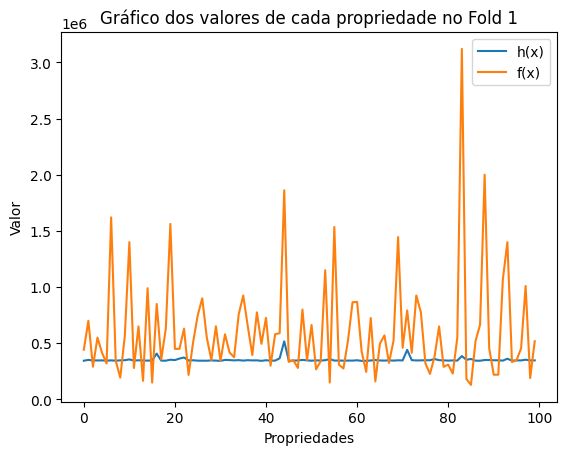

In [ ]:
#Plotando o Grafico do h(x) por f(x) nos testes do Fold 1 (Amostra de tamanho 100 para melhor visualizacao)
fig, ax = plt.subplots()
ax.plot(fold1_hx[:100], label='h(x)')
ax.plot(fold1_fx[:100], label='f(x)')


# Adiciona rótulos aos eixos X e Y, um título para o gráfico e uma legenda para as linhas
ax.set_xlabel('Propriedades')
ax.set_ylabel('Valor')
ax.set_title('Gráfico dos valores de cada propriedade no Fold 1')
ax.legend()

# Exibe o gráfico de linhas
plt.show()

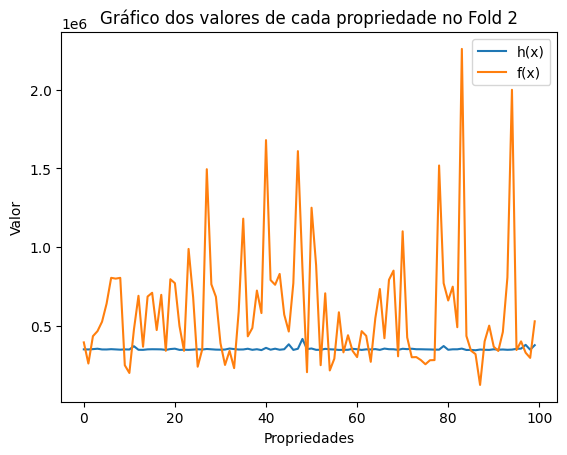

In [ ]:
#Plotando o Grafico do h(x) por f(x) nos testes do Fold 2 (Amostra de tamanho 100 para melhor visualizacao)
fig, ax = plt.subplots()
ax.plot(fold2_hx[:100], label='h(x)')
ax.plot(fold2_fx[:100], label='f(x)')


# Adiciona rótulos aos eixos X e Y, um título para o gráfico e uma legenda para as linhas
ax.set_xlabel('Propriedades')
ax.set_ylabel('Valor')
ax.set_title('Gráfico dos valores de cada propriedade no Fold 2')
ax.legend()

# Exibe o gráfico de linhas
plt.show()

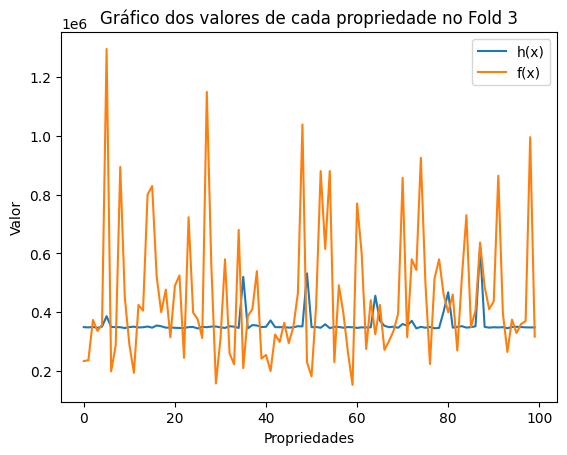

In [ ]:
#Plotando o Grafico do h(x) por f(x) nos testes do Fold 3 (Amostra de tamanho 100 para melhor visualizacao)
fig, ax = plt.subplots()
ax.plot(fold3_hx[:100], label='h(x)')
ax.plot(fold3_fx[:100], label='f(x)')


# Adiciona rótulos aos eixos X e Y, um título para o gráfico e uma legenda para as linhas
ax.set_xlabel('Propriedades')
ax.set_ylabel('Valor')
ax.set_title('Gráfico dos valores de cada propriedade no Fold 3')
ax.legend()

# Exibe o gráfico de linhas
plt.show()

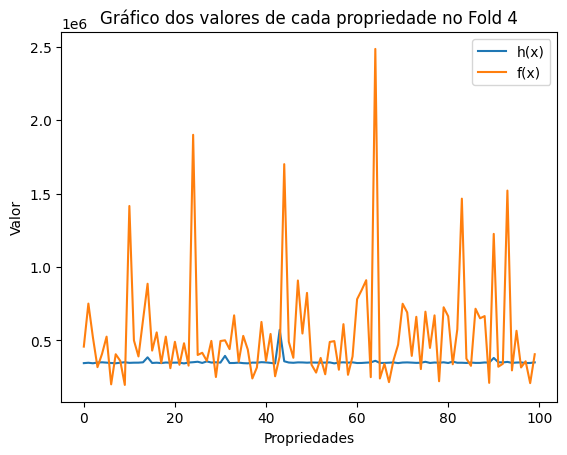

In [ ]:
#Plotando o Grafico do h(x) por f(x) nos testes do Fold 4 (Amostra de tamanho 100 para melhor visualizacao)
fig, ax = plt.subplots()
ax.plot(fold4_hx[:100], label='h(x)')
ax.plot(fold4_fx[:100], label='f(x)')


# Adiciona rótulos aos eixos X e Y, um título para o gráfico e uma legenda para as linhas
ax.set_xlabel('Propriedades')
ax.set_ylabel('Valor')
ax.set_title('Gráfico dos valores de cada propriedade no Fold 4')
ax.legend()

# Exibe o gráfico de linhas
plt.show()

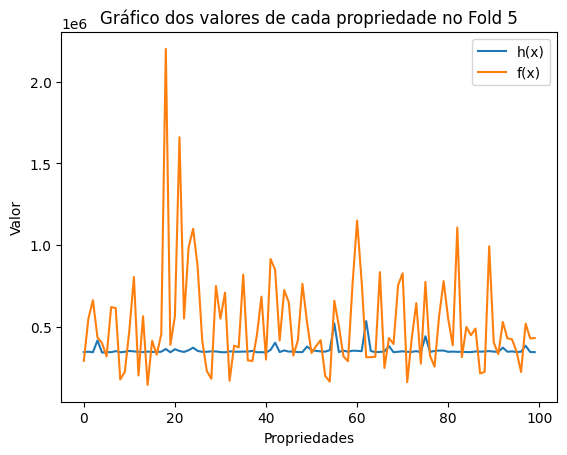

In [ ]:
#Plotando o Grafico do h(x) por f(x) nos testes do Fold 5 (Amostra de tamanho 100 para melhor visualizacao)
fig, ax = plt.subplots()
ax.plot(fold5_hx[:100], label='h(x)')
ax.plot(fold5_fx[:100], label='f(x)')


# Adiciona rótulos aos eixos X e Y, um título para o gráfico e uma legenda para as linhas
ax.set_xlabel('Propriedades')
ax.set_ylabel('Valor')
ax.set_title('Gráfico dos valores de cada propriedade no Fold 5')
ax.legend()

# Exibe o gráfico de linhas
plt.show()

#Valores finais da Loss de cada Fold testando com seu respectivo conjunto teste

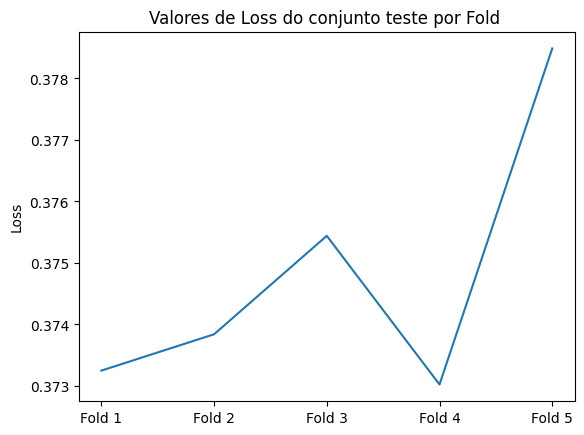

In [ ]:
fig, ax = plt.subplots()

# plotar o gráfico de barras com os valores de loss e ajustar a largura das barras
ax.plot(range(len(test_loss_list)), test_loss_list)

# definir o título do gráfico e os rótulos dos eixos x e y
ax.set_title('Valores de Loss do conjunto teste por Fold ')
ax.set_ylabel('Loss')

# definir as etiquetas do eixo x para cada fold
ax.set_xticks(range(len(test_loss_list)))
ax.set_xticklabels(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])

# exibir o gráfico
plt.show()

#Gráfico da relação entre a aprendizagem do modelo conforme as epochs

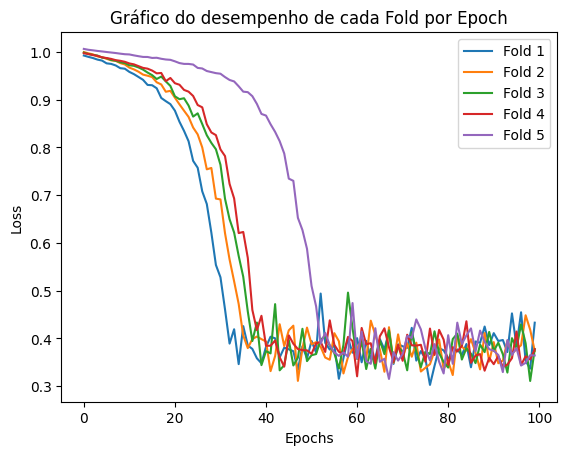

In [ ]:
#Plotagem do gráfico das acuracias de cada fold por epoch
fig, ax = plt.subplots()
loss_list= np.array(loss_list)

# Plota um gráfico de linhas para cada uma das 5 colunas da matriz
for i in range(loss_list.shape[1]):
    ax.plot(loss_list[:, i], label=f'Fold {i+1}')

# Adiciona rótulos aos eixos X e Y, um título para o gráfico e uma legenda para as linhas
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Gráfico do desempenho de cada Fold por Epoch')
ax.legend()

# Exibe o gráfico de linhas
plt.show()

#Aplicando o melhor modelo para predição do conjunto completo

In [ ]:
#Testagem do dataset completo no melhor modelo encontrado para predicao
#dos valores de cada propriedade do dataset
new_prices = best_model(t_X)
total_loss = mean_abs_percentage_error(new_prices.squeeze(), t.tensor(Y).clone().detach())
print(f'Valor final de loss para o melhor modelo aplicando o dataset completo: %.4f' % (total_loss.item()))
new_prices = new_prices.detach().numpy()


Valor final de loss para o melhor modelo aplicando o dataset completo: 0.3747


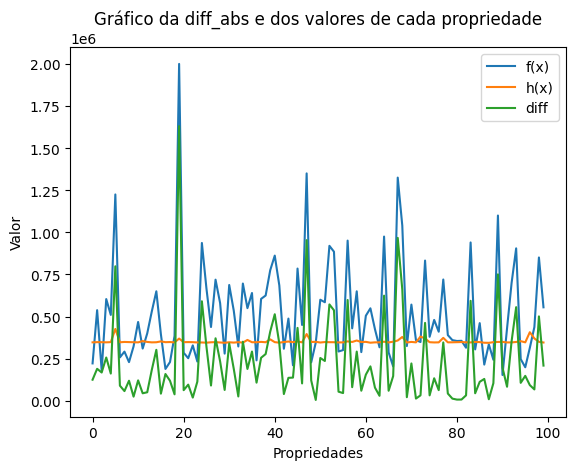

In [ ]:
#Plotagem do gráfico da h(x) e f(x)
fig, ax = plt.subplots()


# Plota um gráfico de linhas para cada uma das 5 colunas da matriz
fx=Y[:1000]
hx=new_prices[:1000]
diff_abs= fx-hx.flatten()
diff_abs=abs(diff_abs)
ax.plot(Y[:100], label='f(x)')
ax.plot(new_prices[:100], label='h(x)')
ax.plot(diff_abs[:100], label='diff')


# Adiciona rótulos aos eixos X e Y, um título para o gráfico e uma legenda para as linhas
ax.set_xlabel('Propriedades')
ax.set_ylabel('Valor')
ax.set_title('Gráfico da diff_abs e dos valores de cada propriedade')
ax.legend()

# Exibe o gráfico de linhas
plt.show()

#Testagem de diferentes modelos de regressão

*   Árvore de decisão
*   Regressão linear

(21611,)
(21611, 16)
Decision Tree
MAE: 141224.43278097035
MSE: 50142934607.06895
RMSE: 223926.18115590894
MAPE: 0.29020754645134494
Coefficient of determination: 0.66


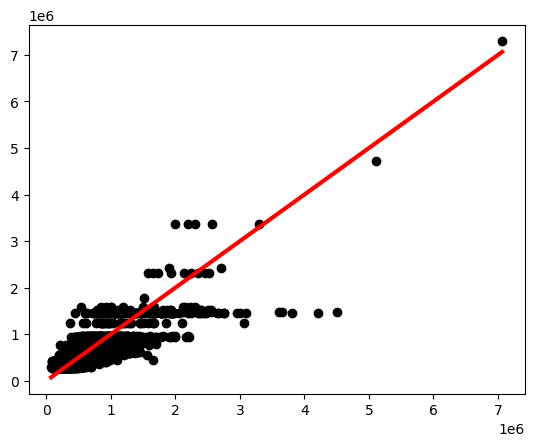

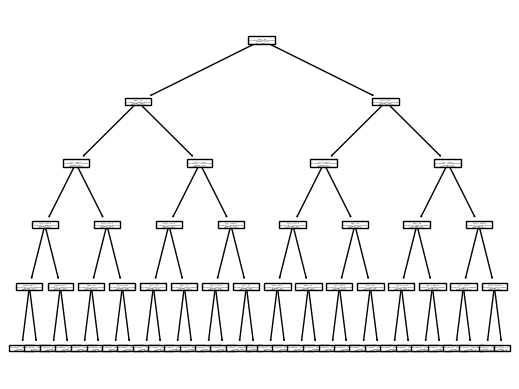

In [ ]:
#Testagem de diferentes modelos de aprendizagem

from sklearn import tree
from sklearn.model_selection import train_test_split # separa os dados em treinamento e teste de forma aleatória

#Recuperando o dataset salvo
data=data_save
y = data['price']
X = data.iloc[:, 1:17]
print(y.shape)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


#Arvore de decisao
clf = tree.DecisionTreeRegressor(random_state=0,max_depth=5)
clf = clf.fit(X_train, y_train)
dt_predicao = clf.predict(X_test)
from sklearn import metrics

print("Decision Tree")
print('MAE:', metrics.mean_absolute_error(y_test, dt_predicao))
print('MSE:', metrics.mean_squared_error(y_test, dt_predicao))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dt_predicao)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, dt_predicao))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test, dt_predicao))

# Plot outputs
plt.scatter(y_test, dt_predicao, color="black")
plt.plot(np.arange(np.min(y_test),np.max(y_test)),
         np.arange(np.min(y_test),np.max(y_test)),color="red", linewidth=3)

#plt.xticks(())
#plt.yticks(())

plt.show()
tree.plot_tree(clf)
plt.show()

In [ ]:
#Modelo de Regressao Linear simples
from sklearn.linear_model import LinearRegression

lr= LinearRegression()
lr.fit(X_train, y_train)
score=lr.score(X_test, y_test)
pred_y=lr.predict(X_test)
print("Decision Tree")
print('MAE:', metrics.mean_absolute_error(y_test, pred_y))
print('MSE:', metrics.mean_squared_error(y_test, pred_y))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_y)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, pred_y))

Decision Tree
MAE: 141852.87445419276
MSE: 49766844123.66501
RMSE: 223084.83615805223
MAPE: 0.291686208051265


#Acrescentando os valores da predição no conjunto do dataset

In [ ]:
#Acrescentando a coluna new_prices ao dataset
data_save['new_price']=new_prices

#Plotagem do mapa iterativo com as propriedades
Conteúdo do mapa:


*   Propriedades e seus atributos
*   HeatMap
*   Valores das propriedades conforme a $h(x)$ e os valores verdadeiros pela $f(x)$



In [ ]:
import folium
from folium.plugins import MarkerCluster, HeatMap

zf = z.ZipFile('/content/drive/MyDrive/Data/House_Sale/House_Sale.zip')
data_map = pd.read_csv(zf.open('kc_house_data.csv'))
data_map=data_map.drop(np.where(data_map['sqft_above'].isnull().values==True)[0])
data_map['new_price']=new_prices
data_map = data_map.sample(frac=1).reset_index(drop=True)


# create the map object
map = folium.Map(location=[47.560171, -122.091307], zoom_start=9)

# create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(map)

# add markers to the cluster
for i in range(12000):
    row = data_map.iloc[i]
    popup_text = f"<div style='font-size: 11pt'><b>Price:</b> U${row['price']:.2f}<br>\
                  <b>New Price:</b> U${row['new_price']:.2f}<br>\
                  <b>Bedrooms:</b> {row['bedrooms']}<br>\
                  <b>Bathrooms:</b> {row['bathrooms']:.2f}<br>\
                  <b>Living Area:</b> {row['sqft_living']:.0f}m2<br>\
                  <b>Lot Area:</b> {row['sqft_lot']:.0f}m2<br>\
                  <b>Floors:</b> {row['floors']:.1f}<br>\
                  <b>Waterfront:</b> {row['waterfront']}<br>\
                  <b>Condition:</b> {row['view']}<br>\
                  <b>Grade:</b> {row['grade']}<br>\
                  <b>Above:</b> {row['sqft_above']:.0f}m2<br>\
                  <b>Basement:</b> {row['sqft_basement']:.0f}m2<br>\
                  <b>Year Built:</b> {row['yr_built']}<br>\
                  <b>Year Renovated:</b> {row['yr_renovated']}<br>\
                  <b>Zipcode:</b> {row['zipcode']}</div>"

    marker = folium.Marker(location=[row['lat'], row['long']],
                           popup=folium.Popup(popup_text, max_width=700),
                           tooltip=f"<div style='font-size: 11pt'><b>ID:</b> {row['id']}</div>",
                           icon=folium.Icon(icon='glyphicon-menu-down', color='blue'))
    
    marker.add_to(marker_cluster)

# add heatmap layer to the map
heat_data = [[row['lat'], row['long']] for index, row in data_map.iterrows()]
HeatMap(heat_data, name='Heat Map').add_to(map)

# add layer control
folium.LayerControl().add_to(map)

# display the map
map
